## Notes
- SDXL works better with 1024 by 1024 images. lower resolution -> lower quality generated image
- The conditional scale affects how much of the original image will be preeserved, since this is an outpaint, it's safe to use higher values, for inpainting and complex images is better to use lower values around 0.5.

# Outpainting with Controlnet

Import the required libraries


In [ ]:
from diffusers import (
    AutoPipelineForImage2Image,
    ControlNetModel,
    DPMSolverMultistepScheduler,
    StableDiffusionXLControlNetPipeline,
)
from diffusers.image_processor import IPAdapterMaskProcessor
import torch
import random
from io import BytesIO
import requests
import torch
from PIL import Image, ImageDraw

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Load the pretrained Controlnet model from diffusers

In [2]:
controlnet = ControlNetModel.from_pretrained(
    "destitech/controlnet-inpaint-dreamer-sdxl", torch_dtype=torch.float16, variant="fp16"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/2.50G [00:00<?, ?B/s]

Load image.

The considered image already has white background, so we plug it as Alpha channel. This area will be painted

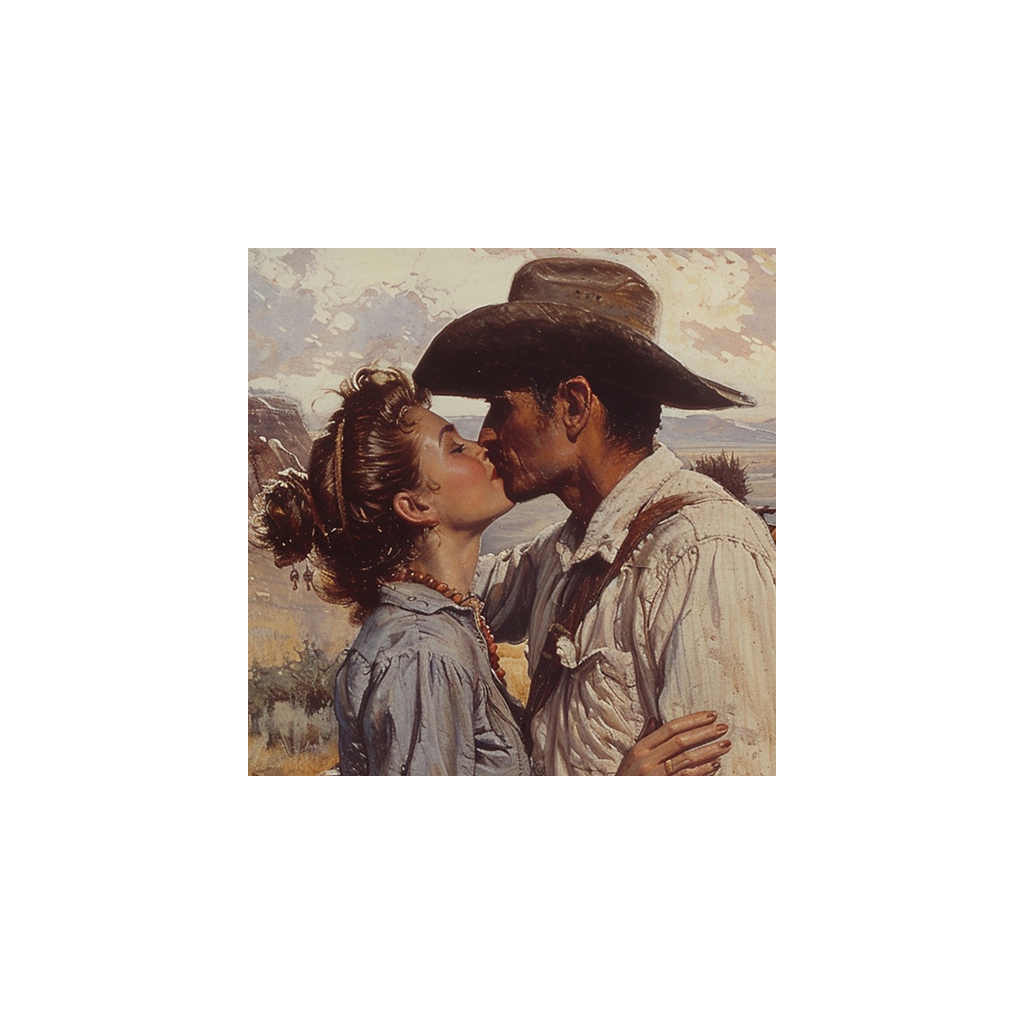

In [3]:
import urllib
import numpy as np

url = "https://cdn-uploads.huggingface.co/production/uploads/63df091910678851bb0cd0e0/09_EwT8WqwRamdLdCzDLv.png"
urllib.request.urlretrieve(url, "couple.png")
control_image = Image.open(r"couple.png")
control_image
# shape: (1024, 1024, 4)

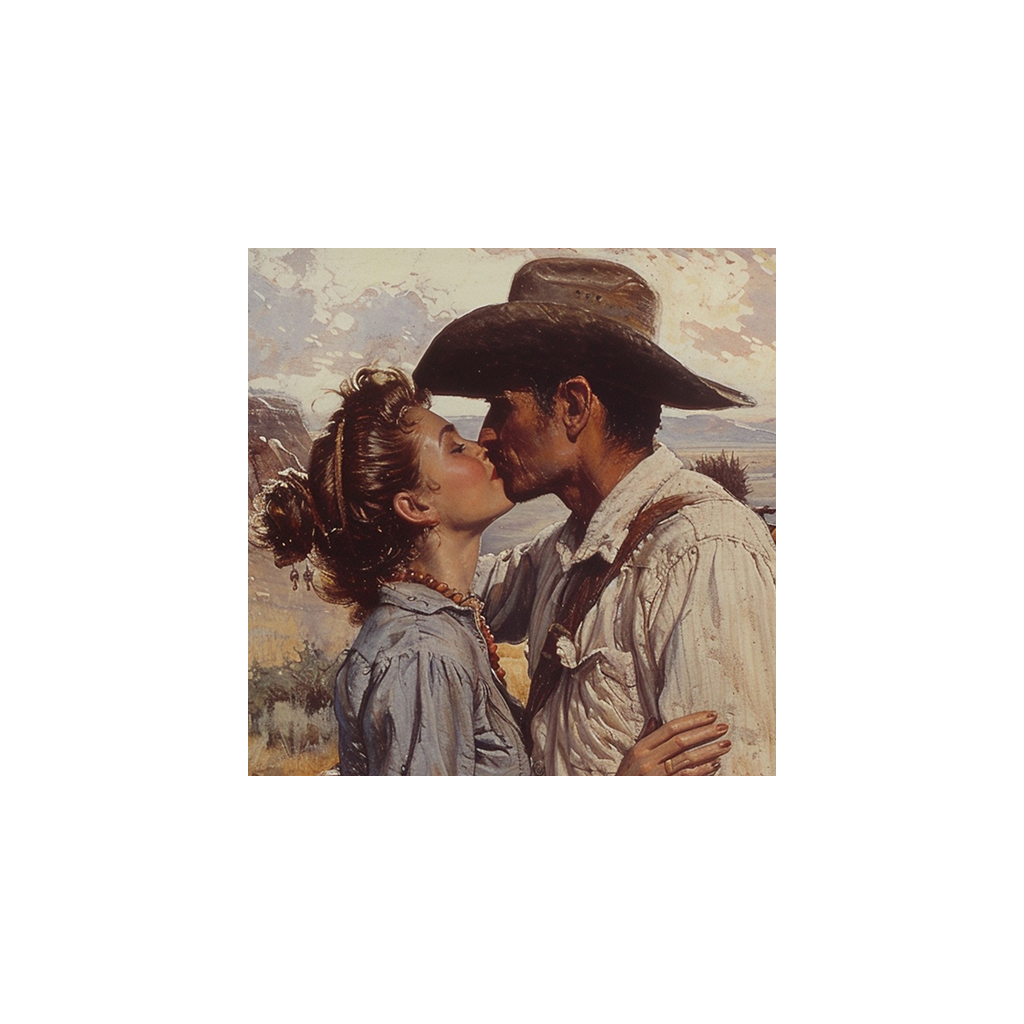

In [ ]:
# create a mask. RGBA for true color (RGB) and Alpha color (A)
new_controlnet_image = Image.new("RGBA", control_image.size, "WHITE")
new_controlnet_image.alpha_composite(control_image)
new_controlnet_image
# new_controlnet_image.shape: (1024, 1024, 4)

Generate basic prompt. Also you can add negative prompt.

Use Generator for random number generator in the pipeline (for sampling in the denoising process of the diffusion model)

Load pretrained Stable Diffusion Controlnet Pipeline. Choose fp16 qantization and pass loaded pretrained controlnet.


In [ ]:
prompt = "high quality photo of a couple in front of eifel tower, highly detailed, dramatic ambient light, cinematic, renessance style, dynamic background"
negative_prompt = ''
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = torch.Generator(device=device).manual_seed(42)

In [5]:
pipeline = StableDiffusionXLControlNetPipeline.from_pretrained(
    "RunDiffusion/Juggernaut-XL-v9",
    torch_dtype=torch.float16,
    variant="fp16",
    controlnet=controlnet,
).to(device)


model_index.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/496 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Exlore parameters impact

Lets see how parameters can affect the results

**Guidance scale step** - strength of the classifier-free guidance. The higher value is, the more a generated image follows a prompt. Lower values are useful for getting more various pictures - assign the model some freedom.



In [7]:
imgs_guidance_scale = []
guidance_scale_range = [2,4,6.5,9,13]

for i in guidance_scale_range:
    image = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=1024,
        width=1024,
        guidance_scale=i,
        num_inference_steps=25,
        generator=generator,
        image=new_controlnet_image,
        controlnet_conditioning_scale=0.9,
        control_guidance_end=0.9,
    ).images[0]
    imgs_guidance_scale.append(image)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[]

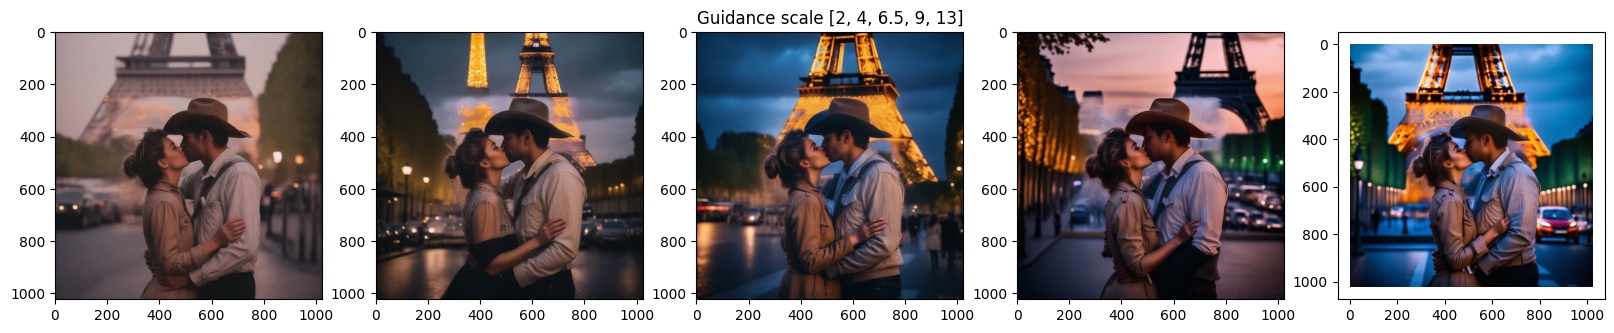

In [8]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=5, figsize=(20, 20))
for i in range(5):
  ax = axs[i]
  ax.use_sticky_edges = False
  ax.imshow(imgs_guidance_scale[i])

axs[2].set_title(f"Guidance scale [2, 4, 6.5, 9, 13]")
plt.plot()

**Num inference steps** - number of denoising steps in the diffusion. Obviously, the higher value is, the more time generation takes and the more detailed image is produced (you can see generation time in the cell output). The problem here is time-quality trade-off.

In [9]:
imgs_num_inference_steps = []
num_inference_steps_range = [5, 15, 25, 35, 45]

for i in num_inference_steps_range:
    image = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=1024,
        width=1024,
        guidance_scale=6.5,
        num_inference_steps=i,
        generator=generator,
        image=new_controlnet_image,
        controlnet_conditioning_scale=0.9,
        control_guidance_end=0.9,
    ).images[0]
    imgs_num_inference_steps.append(image)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[]

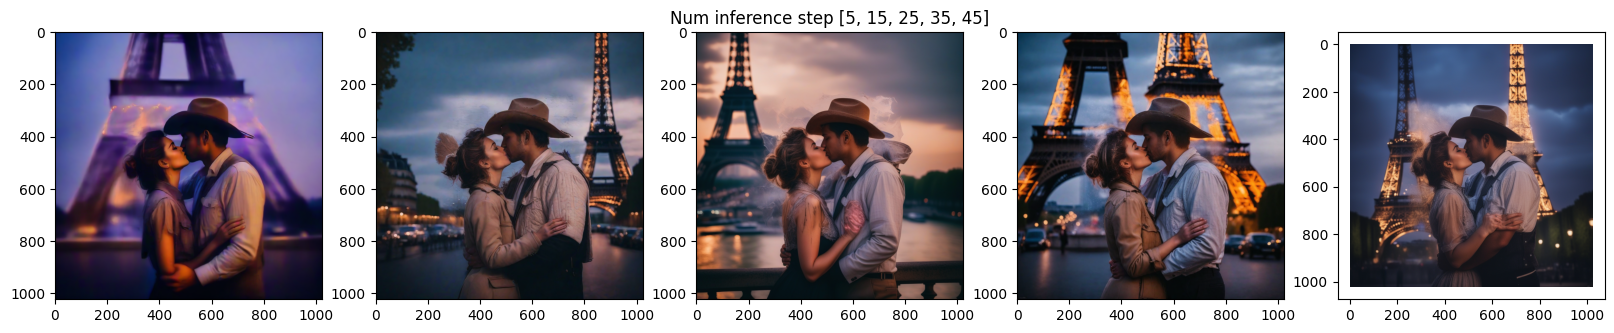

In [10]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=5, figsize=(20, 20))
for i in range(5):
  ax = axs[i]
  ax.use_sticky_edges = False
  ax.imshow(imgs_num_inference_steps[i])

axs[2].set_title("Num inference step [5, 15, 25, 35, 45]")
plt.plot()

**Condition scale** - since we use controlnet, this value controls the Controlnet influence. A higher value ensures that the structure from the original control image strongly impacts the generation, resulting in more faithful preservation of the original image.

>The controlnet_conditioning_scale parameter determines how much weight to assign to the conditioning inputs. A value of 0.5 is recommended for good generalization ... [Source](https://huggingface.co/docs/diffusers/using-diffusers/controlnet#controlnet-with-stable-diffusion-xl)

In [ ]:
imgs_conditioning_scale =  []
conditioning_scale_range = [0.1, 0.3, 0.5, 0.7, 0.9]

for i in conditioning_scale_range:
    image = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=1024,
        width=1024,
        guidance_scale=7,
        num_inference_steps=13,
        generator=generator,
        image=new_controlnet_image,
        controlnet_conditioning_scale=i,
        control_guidance_end=0.9,
    ).images[0]
    imgs_conditioning_scale.append(image)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

[]

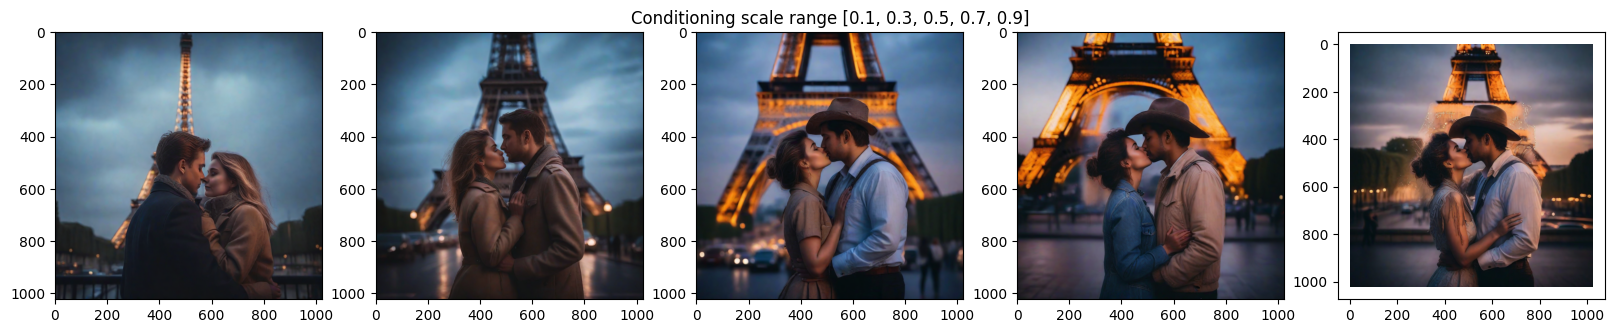

In [17]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=5, figsize=(20, 20))

for i in range(5):
  ax = axs[i]
  ax.use_sticky_edges = False
  ax.imshow(imgs_conditioning_scale[i])

axs[2].set_title(f"Conditioning scale range [0.1, 0.3, 0.5, 0.7, 0.9]")
plt.plot()

**Control guidance end** - timestep where the ControlNet guidance stops influencing the diffusion process - how long ControlNet's guidance is applied during the inference process.


In [ ]:
imgs_control_guidance_end =  []
control_guidance_end_range = [0.1, 0.3, 0.5, 0.7, 0.9]

for i in control_guidance_end_range:
    image = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=1024,
        width=1024,
        guidance_scale=7,
        num_inference_steps=25,
        generator=generator,
        image=new_controlnet_image,
        controlnet_conditioning_scale=0.7,
        control_guidance_end=i,
    ).images[0]
    imgs_control_guidance_end.append(image)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

[]

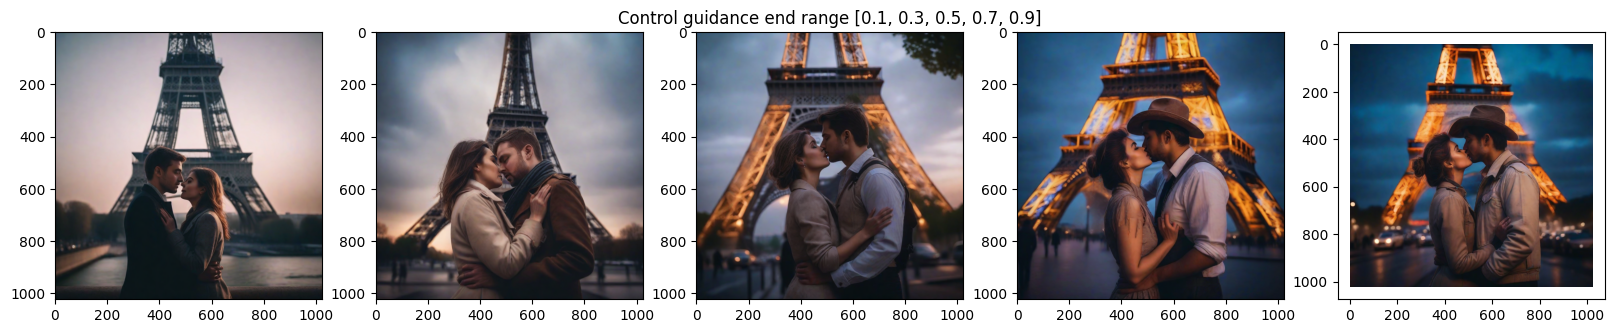

In [19]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=5, figsize=(20, 20))

for i in range(5):
  ax = axs[i]
  ax.use_sticky_edges = False
  ax.imshow(imgs_control_guidance_end[i])

axs[2].set_title(f"Control guidance end range [0.1, 0.3, 0.5, 0.7, 0.9]")
plt.plot()

Outpainting assumes a new image part around the passed image, so the initial image should be preserved as much as possible. That's why we should choose controlnet_conditioning_scale=0.9 and control_guidance_end=0.9. Controlnet keeps starting image the same and following the prompt very well.

# IPAdapter

Overall generation consists of:
- Base model: RunDiffusion/Juggernaut-XL-v9, from StableDiffusionXLControlNetPipeline
- Generator: random number sampler for the denoising process;
- ControlNet: guides generation based on control images to maintain structure;
- Scheduler: governs the noise reduction process to ensure efficient and quality image generation;
- IPAdapter: adds an extra layer of control, embedding reference styles or features;
- Processor: prepares auxiliary input (masks) to refine specific areas of the image during generation.

Load Scheduler from the config pipeline. **Scheduler** - determines how noise is reduced step by step during the denoising process. DPM (multistep solver) reduces the number of required steps but still maintains high quality. Karras noise - improves the stability of generation process.

Load IPAdapter in the pipeline. **IPAdapter** - adds additional control over the diffusion process by adding image-specific embeddings -> better adaptiation to specific features or styles. Influence of IPAdapter also can be set.

[REF](https://huggingface.co/blog/OzzyGT/outpainting-controlnet). Images are also taken from OzzyGT HuggingFace profile.

In [6]:
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline.scheduler.config.use_karras_sigmas = True

pipeline.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder="sdxl_models",
    weight_name="ip-adapter-plus_sdxl_vit-h.safetensors",
    image_encoder_folder="models/image_encoder",
)
pipeline.set_ip_adapter_scale(0.4)


ip-adapter-plus_sdxl_vit-h.safetensors:   0%|          | 0.00/848M [00:00<?, ?B/s]

models/image_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.53G [00:00<?, ?B/s]

Load image and its mask

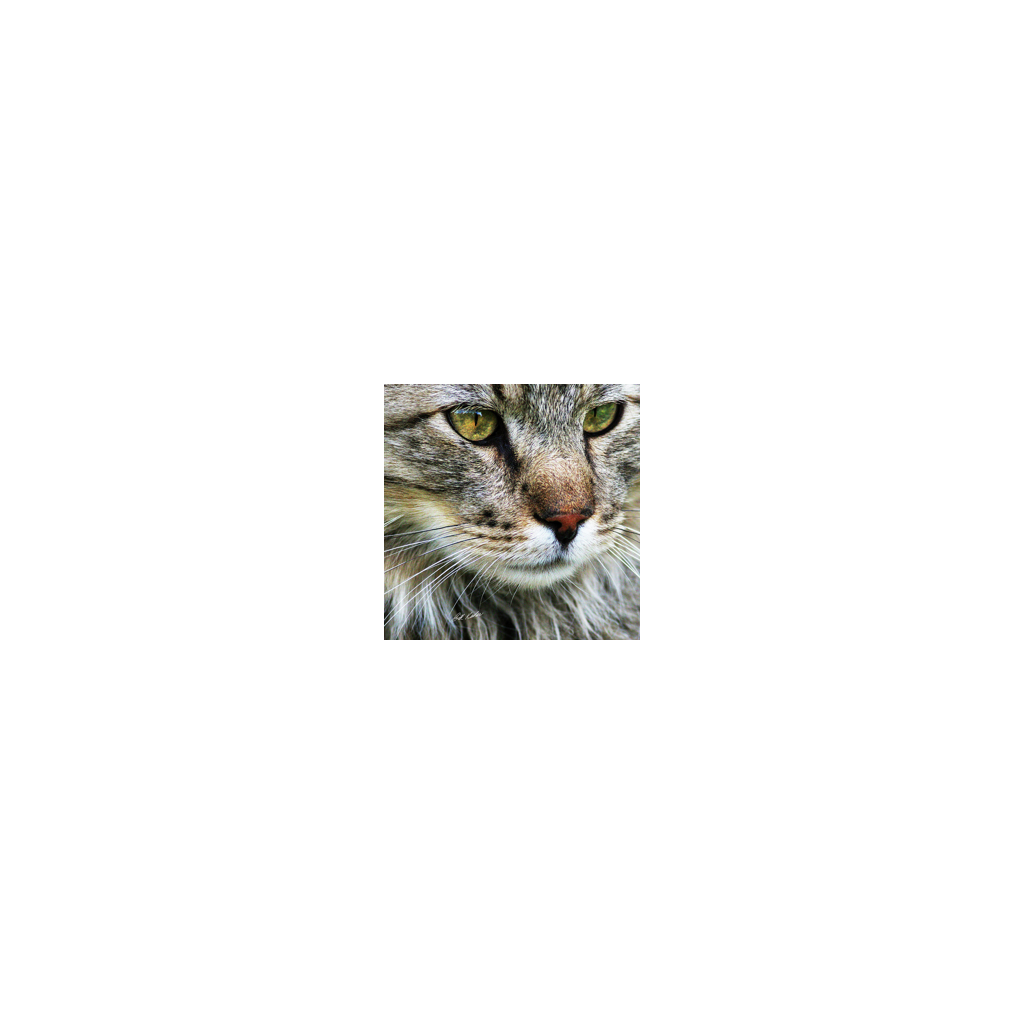

In [ ]:
def load_from_path(path):
  return Image.open(path)

def resize_image(img, size=256):
  return img.resize((size, size))

def pad_and_mask_image(img, size=1024):
  smallest = min(img.size)
  img = img.resize((smallest, smallest))

  new_image = Image.new("RGB", (size, size), (255,255,255))
  offset = ((size - img.width) // 2, (size - img.height) // 2)
  new_image.paste(img, offset)

  mask_image = Image.new("L", (size, size), 0)
  draw = ImageDraw.Draw(mask_image)
  draw.rectangle(
      [offset, (offset[0] + img.width, offset[1] + img.height)],
      fill=255
  )

  return new_image, mask_image


img = load_from_path('cat.jpg')
img = resize_image(img, 256)
ip_cat_image = img

img, mask = pad_and_mask_image(img, 1024)
ip_mask = mask

control_image = img.convert("RGBA")
new_controlnet_image = Image.new("RGBA", control_image.size, "WHITE")
new_controlnet_image.alpha_composite(control_image)
img

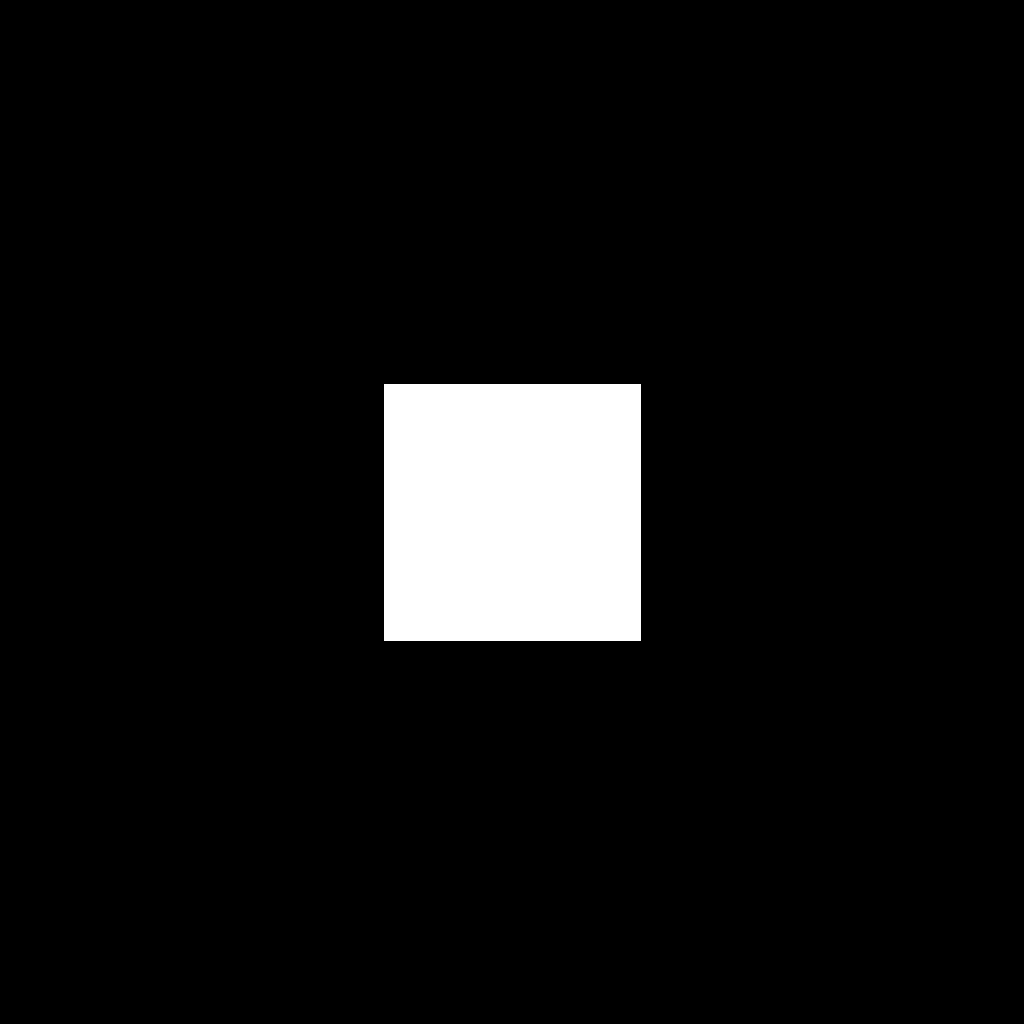

In [ ]:
ip_cat_image

In [ ]:
ip_mask

In [ ]:
new_controlnet_image

**IPAdapterMaskProcessor** - process input masks providing a structured guidance for generation.

In [ ]:
processor = IPAdapterMaskProcessor()

# takes Alpha channel (mask) and resizes it to a desired resolution (1024 by 1024)
ip_masks = processor.preprocess(ip_mask, height=1024, width=1024)

In [ ]:
prompt = "high quality photo of a cat playing chess, cat holds a queen, highly detailed, nervous competition, professional, dramatic ambient light, cinematic, dynamic background, focus"
negative_prompt = "simple image, cat is sitting, cats paws are under him"

seed = 12345
generator = torch.Generator(device="cpu").manual_seed(seed)

latents = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    height=1024,
    width=1024,
    guidance_scale=9,
    num_inference_steps=30,
    generator=generator,
    image=new_controlnet_image,
    controlnet_conditioning_scale=0.9,
    control_guidance_end=0.9,
    # additions for IP Adapter
    ip_adapter_image=ip_cat_image,
    cross_attention_kwargs={"ip_adapter_masks": ip_masks},
    output_type="latent", # to prevent details loss and quality lowering during encoding-decoding process, stay in the latent space as much as possible
).images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

In [10]:
latents

tensor([[[-1.8975, -2.2637, -2.1738,  ..., -0.2478, -0.7349, -1.5342],
         [-2.0508, -2.1230, -2.4395,  ..., -0.5566, -0.8936, -1.3096],
         [-2.0410, -2.5801, -1.1943,  ..., -0.4783, -0.3191, -1.0205],
         ...,
         [-1.0176, -1.0293, -1.3359,  ..., -1.0928, -1.4814, -1.0098],
         [-1.0039, -1.5557, -1.0820,  ..., -1.2100, -0.4561, -0.5293],
         [-0.2030, -0.4973, -1.3613,  ...,  0.3120,  0.2556,  0.5967]],

        [[-0.4380, -0.7241, -0.2649,  ...,  1.2637,  1.0400,  0.3533],
         [-0.4834, -0.0306, -1.4609,  ...,  0.9238,  1.0098,  1.0215],
         [-0.4238, -1.1621, -0.4407,  ...,  1.3018,  1.3369,  0.9653],
         ...,
         [-0.5737,  0.1433,  0.6636,  ...,  0.8677, -0.1296,  0.1726],
         [ 0.1141, -0.7681,  0.0067,  ..., -0.0042,  0.2976, -0.1126],
         [ 0.5117,  0.2903, -0.9385,  ...,  0.0501, -0.2529,  0.5537]],

        [[ 0.7642, -0.2122, -0.0926,  ...,  0.3872,  0.2260, -0.9897],
         [ 0.8335, -0.5879,  0.4124,  ...,  0

Plug Image to Image pipeline (AutoPipelineForImage2Image) to generate image from latents

In [ ]:
pipeline_img2img = AutoPipelineForImage2Image.from_pipe(pipeline, controlnet=None)
prompt = "cinematic film of a cat playing chess, highly detailed, nervous competition, high budget hollywood movie, cinemascope, epic, gorgeous, film grain"
negative_prompt = 'simple image, cat is sitting, cats paws are under him'

In [ ]:
image = pipeline_img2img(
    prompt=prompt,
    negative_prompt=negative_prompt,
    guidance_scale=4,
    num_inference_steps=25, # default value
    generator=generator,    # the same generator
    image=latents,          # use latents from StableDiffusionXLControlNetPipeline pipeline
    strength=0.3,
    ip_adapter_image=ip_cat_image,
    cross_attention_kwargs={"ip_adapter_masks": ip_masks},
).images[0]

  0%|          | 0/7 [00:00<?, ?it/s]

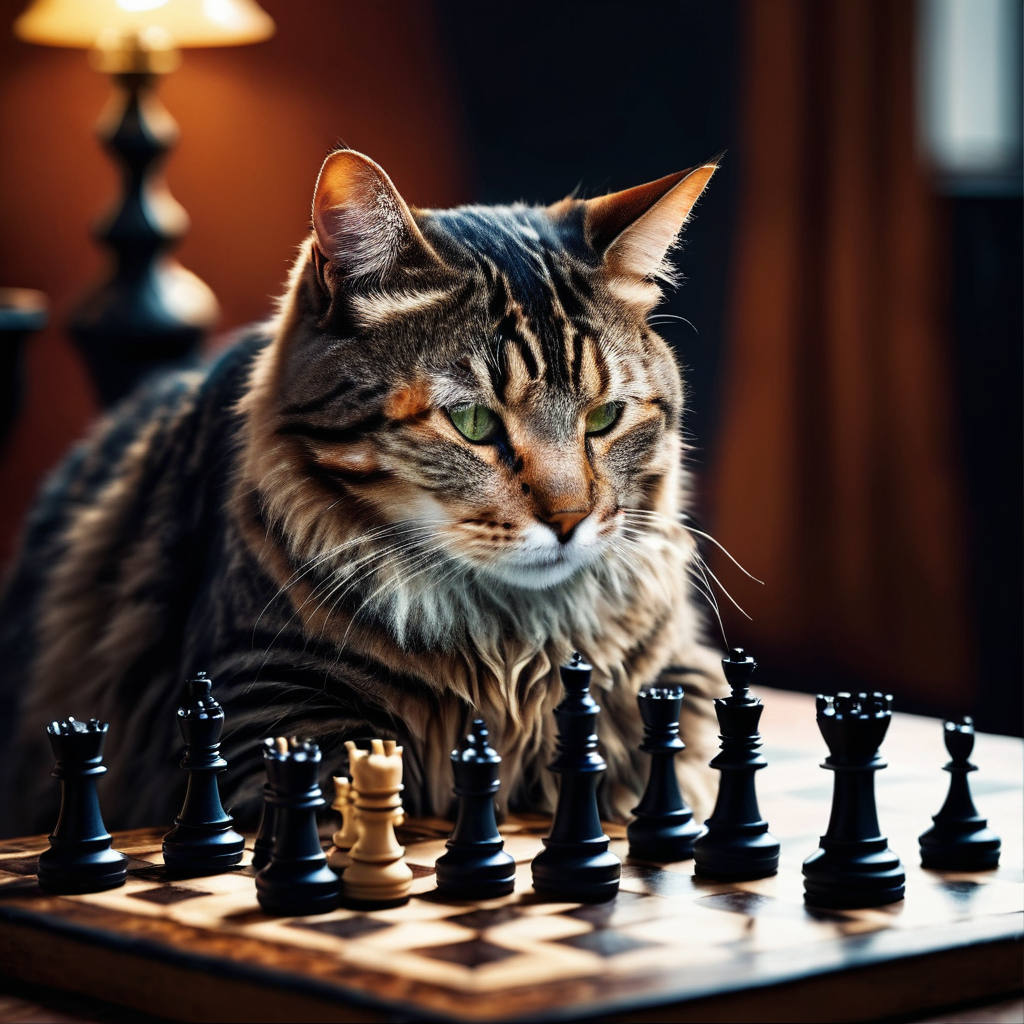

In [15]:
image